# Quickstart: Use Cases and Examples with *Open Bandit Pipeline*
---
This notebook demonstrates an example of conducting an OPE of the performance of Bernoulli Thompson Sampling (BernoulliTS) as an evaluation policy using OPE estimators and logged bandit feedback generated by the Random policy (behavior policy).

Our example with Open Bandit Dataset (OBD) contains the follwoing three major steps:
- (1) Data Loading and Preprocessing
- (2) Off-Policy Learning
- (3) Off-Policy Evaluation

In [1]:
from pathlib import Path
from sklearn.linear_model import LogisticRegression
# import open bandit pipeline (obp)
from obp.dataset import OpenBanditDataset
from obp.policy import BernoulliTS
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust
)

## (1) Data Loading and Preprocessing

We prepare easy-to-use data loader for Open Bandit Dataset, **OpenBanditDataset** class in dataset module. <br>
It takes behavior policy ('bts' or 'random') and campaign ('all', 'men', or 'women') as inputs and provides dataset preprocessing.

In [2]:
# (1) Data loading and preprocessing
# specify path of dataset
data_path = Path('.').resolve().parents[1] / 'obd'
# load and preprocess raw data in "All" campaign collected by the Random policy (behavior policy here)
dataset = OpenBanditDataset(behavior_policy='random', campaign='all', data_path=data_path)
# obtain logged bandit feedback generated by behavior polciy
bandit_feedback = dataset.obtain_batch_bandit_feedback()

# `bandit_feedback` is a dictionary storing logged bandit feedback
bandit_feedback.keys()

dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'reward_test', 'pscore', 'context', 'action_context'])

### let's see some properties of the dataset class

In [3]:
# name of the dataset is 'obd' (open bandit dataset)
dataset.dataset_name

'obd'

In [4]:
# number of actions of the "Women's" campaign is 46
dataset.n_actions

80

In [5]:
# small sample example data has 10,000 rounds
dataset.n_rounds

10000

In [6]:
# default context (feature) engineering creates context vector with 19 dimensions
dataset.dim_context

20

In [7]:
# ZOZOTOWN recommendation iterface has three positios
# (please see https://github.com/st-tech/zr-obp/blob/master/images/recommended_fashion_items.png)
dataset.len_list

3

## (2) Offline Bandit Simulation

After preparing the data, we now run **offline bandit simulation**.

We use **Bernoulli TS** impelemted in policy module as an evaluation policy. By activating the `is_zozotown_prior` argument of BernoulliTS, we can replicate BernoulliTS used in ZOZOTOWN production.

In [8]:
# (2) Offline Bandit Simulation
# define evaluation policy
evaluation_policy = BernoulliTS(
    n_actions=dataset.n_actions, 
    len_list=dataset.len_list, 
    is_zozotown_prior=True, # replicate the policy in the ZOZOTOWN production
    campaign="all",
    random_state=12345
)

# compute the distribution over actions by the evaluation policy using Monte Carlo simulation
action_dist = evaluation_policy.compute_batch_action_dist(
    n_sim=100000, n_rounds=bandit_feedback["n_rounds"]
)

# action_dist is an array of shape (n_rounds, n_actions, len_list) 
# representing the distribution over actions by the counterfactual policy
action_dist

array([[[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       [[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       [[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       ...,

       [[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       [[0.01078, 0.00931, 0.00917],
  

## (3) Off-Policy Evaluation (OPE)

Our final step is **off-policy evaluation**, which attempts to estimate the performance of bandit algorithms using log data generated by offline bandit simulation. 

We use the *InverseProbabilityWeighting (IPW)*, *DirectMethod (DM)*, and *Doubly Robust (DR)* estimators as OPE estimators and estiamte the performance of Bernoulli TS using the logged bandit feedback. Finally, we summarize and visualize the OPE results.

In [9]:
# estimate the policy value of BernoulliTS based on its distribution over actions
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,  
    regression_model=RegressionModel(
        n_actions=dataset.n_actions,
        len_list=dataset.len_list,
        action_context=dataset.action_context,
        base_model=LogisticRegression(C=100, random_state=12345)
    ),
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
)

# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(action_dist=action_dist)

In [10]:
# ground-truth policy value of the random policy
# , which is the empirical mean of the factual (observed) rewards (on-policy estimation)
ground_truth = bandit_feedback['reward'].mean()

# add estimated policy value of the evaluation policy (the BernoulliTS policy)
# relative to the ground-truth policy value of the behavior policy (the Random policy here)
estimated_policy_value['relative_estimated_policy_value'] =\
        estimated_policy_value.estimated_policy_value / ground_truth

In [11]:
# the estimated policy value of the evaluation policy (the BernoulliTS policy)
estimated_policy_value

,estimated_policy_value,relative_estimated_policy_value
ipw,0.004553,1.198126
dm,0.003492,0.919066
dr,0.004740,1.247439


In [12]:
# estimated confidence intervals of policy value of BernoulliTS by OPE estimators
# (`mean` values in this dataframe is also estimated via the non-parametric bootstrap procedure 
# and is a bit different from the above values in `estimated_policy_value`)
estimated_interval

,mean,95.0% CI (lower),95.0% CI (upper)
ipw,0.004584,0.001677,0.009494
dm,0.003494,0.003432,0.003566
dr,0.004707,0.002126,0.008998


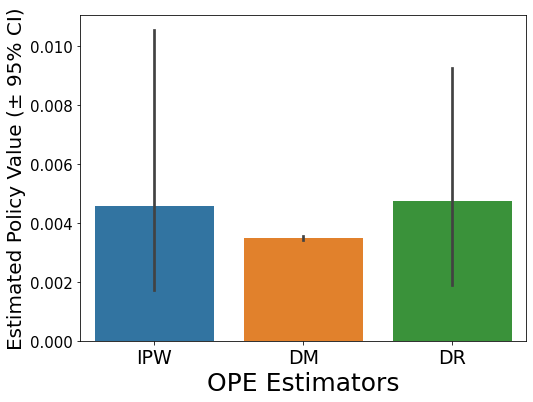

In [13]:
# visualize the estimated policy values of BernoulliTS by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(action_dist=action_dist)

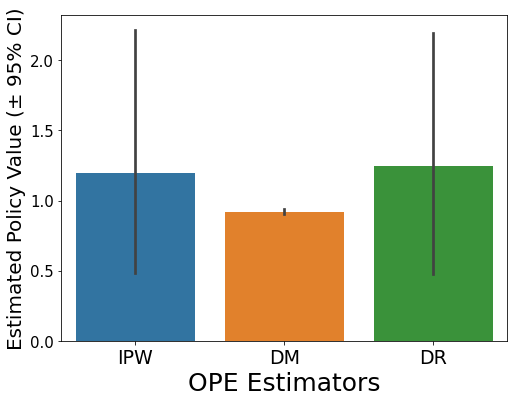

In [14]:
# by activating the `relative` option
# we can visualize the estimated policy value of the evaluation policy
# relative to the ground-truth policy value of the behavior policy
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    relative=True
)

Note that the example of OPE here is with the small size example version of our dataset, 
and please use the full size version to produce more reasonable results